In [33]:
import os, random, operator, sys
from collections import Counter
import random
import collections
import math
import sys
from util import *
import matplotlib as plt


## 一些功能函数  
需要阅读这些函数来对实验中用到的数据结构，步骤有一些理解

In [34]:
def dotProduct(d1, d2):
    """
    @param dict d1: a feature vector represented by a mapping from a feature (string) to a weight (float).
    @param dict d2: same as d1
    @return float: the dot product between d1 and d2
    """
    if len(d1) < len(d2):
        return dotProduct(d2, d1)
    else:
        return sum(d1.get(f, 0) * v for f, v in d2.items())


In [35]:
def increment(d1, scale, d2):
    """
    Implements d1 += scale * d2 for sparse vectors.
    @param dict d1: the feature vector which is mutated.
    @param float scale
    @param dict d2: a feature vector.
    """
    for f, v in d2.items():
        d1[f] = d1.get(f, 0) + v * scale


In [36]:
def readExamples(path):
    '''
    读取数据
    '''
    examples = []
    for line in open(path, encoding = "ISO-8859-1"):
        # Format of each line: <output label (+1 or -1)> <input sentence>
        y, x = line.split(' ', 1)
        examples.append((x.strip(), int(y)))
    print('Read %d examples from %s' % (len(examples), path))
    return examples


In [37]:
def evaluatePredictor(examples, predictor):
    '''
    在|examples|上测试|predictor|的性能，返回错误率
    '''
    error = 0
    for x, y in examples:
        if predictor(x) != y:
            error += 1
    return 1.0 * error / len(examples)

## Feature extrator (Your codes here)  

### (1) 使用BOW作为特征  
(a) 复习BOW  
词袋模型（Bag of Words, BoW）是一种文本表示方法，用于将文本转换为定长的数值向量。此方法忽略文本中词的顺序，只考虑词汇在文档中出现的频率。每个文档由一个向量表示，向量的每个元素对应词汇表中的一个词，其值反映该词在文档中出现的次数或权重。  

(b) 如何把一个句子（字符串）转化成BOW的特征？  
* 词汇表构建：分析所有文档，构建词汇表，即所有不重复词项的集合。  
* 文档向量化：对于每个文档（在这里是指句子），根据词汇表生成一个向量。向量的长度等于词汇表的大小。遍历句子中的每个词，如果词出现在词汇表中，则在向量的相应位置（与词汇表中的词对应的索引）增加计数。

In [38]:
from collections import Counter

def extractFeatures_Bow(x):
    """
    从字符串x中提取特征
    @param string x: 
    @return dict: feature vector representation of x.
    """
    words = x.split()  # 将文本分割成单词列表
    feat = Counter(words)  # 计算各个单词出现的次数
    return dict(feat)

### (2) 使用N-Gram作为特征  
(a) 复习N-Gram相关的内容  
N-Gram模型是一种基于统计的语言模型，用于预测下一个项的概率。它通过分析文本中N个连续项（如字或词）的序列来实现。N-Gram可以捕捉到一定长度的上下文信息，有助于理解文本的语义。  

(b) 字级别N-Gram还是词语级别？  
N-Gram可以是字级别（字符级别）也可以是词语级别，具体取决于分析的需求：  
* 字级别N-Gram：分析的序列是字符序列，适合于拼写检查、输入法词预测等场景。  
* 词语级别N-Gram：分析的序列是词序列，适合于文本分类、搜索引擎等场景。  

(c) 如何把一个句子（字符串）转化成N-Gram的特征？  
* 选择N值：确定要使用的N-Gram的N值（例如，bigrams为2, trigrams为3）。  
* 生成N-Grams：将句子分割成N-Gram序列。对于词语级别N-Gram，首先需要将句子分词。  
* 向量化：构建一个向量来表示这个句子。向量的长度由语料库中所有唯一N-Gram的数量决定。对于句子中的每个N-Gram，增加向量中相应位置的计数。这可以通过构建N-Gram的词汇表并将每个N-Gram映射到一个唯一索引来实现。  


In [39]:
from nltk import ngrams
from collections import Counter

def extractFeatures_Ngram(x, n=2):
    """
    从字符串x中提取N-gram特征
    @param string x: 输入的文本
    @param int n: N-gram中N的值
    @return dict: 文本x的特征向量表示
    """
    # 将文本分割成单词列表
    words = x.split()
    # 生成并获取n-grams
    n_grams = ngrams(words, n)
    # 计算n-grams的频率
    feat = Counter(n_grams)
    # 返回特征字典
    return dict(feat)

### （3） 使用word2vec作为特征  
(a) 获得词向量。你可以借鉴第一次的作业，使用gensim来自己训练一个word2vec, 或者加载预训练过的word2vec(gensim的网站上有说明如何下载并使用预训练过的词向量)。  
(b) 考虑如何使用词向量得到句子的表示向量（feature）。  
(c) 将向量转化为其余部分可以处理的形式（如：dict）  
(d) 考虑如何**更好地**使用词向量得到句子的表示向量（feature）。  

提示: 在ipynb的代码块中可以使用! 来执行命令行中的命令, 例如  
```
!pip install gensim  
```

### (4) Test your feature extractor  
实现了特征提取函数之后，可以简单地测试输出的正确性

In [40]:
extractFeatures_Bow("a truly wonderful tale combined with stunning animation .")

{'a': 1,
 'truly': 1,
 'wonderful': 1,
 'tale': 1,
 'combined': 1,
 'with': 1,
 'stunning': 1,
 'animation': 1,
 '.': 1}

## 学习与梯度更新  
你需要理解题目中的loss_function, 自行推导出weights的更新公式，  
通过对训练集上样本的迭代，来更新weights

In [41]:
import collections
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def learnPredictor(trainExamples, testExamples, featureExtractor, numIters, eta):
    '''
    给定训练数据和测试数据，特征提取器|featureExtractor|、训练轮数|numIters|和学习率|eta|，
    返回学习后的权重weights
    你需要实现随机梯度下降优化权重
    '''
    weights = collections.defaultdict(float)  # 初始化权重为默认值为0的字典
    trainErrors = []  # 存储训练误差率
    testErrors = []   # 存储测试误差率
    trainLosses = []  # 存储训练损失
    testLosses = []   # 存储测试损失

    for i in range(numIters):  # 迭代训练 numIters 次
        totalTrainLoss = 0  # 记录训练集总损失
        totalTestLoss = 0   # 记录测试集总损失

        # 在训练集上进行训练
        for x, y in trainExamples:
            featureVector = featureExtractor(x)  # 提取特征向量
            predicted = dotProduct(featureVector, weights)  # 计算预测值
            loss = max(0, 1 - predicted * y)  # 计算损失
            totalTrainLoss += loss  # 累加训练集损失
            if loss > 0:  # 如果存在损失，则更新权重
                for feature, value in featureVector.items():
                    weights[feature] += eta * value * y

        # 在测试集上计算损失
        for x, y in testExamples:
            featureVector = featureExtractor(x)  # 提取特征向量
            predicted = dotProduct(featureVector, weights)  # 计算预测值
            loss = max(0, 1 - predicted * y)  # 计算损失
            totalTestLoss += loss  # 累加测试集损失

        # 计算并记录训练集和测试集的误差率
        trainError = evaluatePredictor(trainExamples, lambda x: (1 if dotProduct(featureExtractor(x), weights) >= 0 else -1))
        testError = evaluatePredictor(testExamples, lambda x: (1 if dotProduct(featureExtractor(x), weights) >= 0 else -1))
        trainErrors.append(trainError)
        testErrors.append(testError)

        # 计算并记录训练集和测试集的平均损失
        trainLosses.append(totalTrainLoss / len(trainExamples))
        testLosses.append(totalTestLoss / len(testExamples))
        # 打印每轮迭代的训练和测试结果
        print("At iteration %d, loss on training set is %f, loss on test set is %f, error rate on training set is %f, error rate on test set is %f" %
              (i, totalTrainLoss / len(trainExamples), totalTestLoss / len(testExamples), trainError, testError))

    plt.figure(figsize=(12, 5))
    # 绘制损失随迭代次数变化的曲线
    plt.subplot(1, 2, 1)
    plt.plot(range(numIters), trainLosses, label="Train Loss")
    plt.plot(range(numIters), testLosses, label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss vs. Epoch")
    plt.legend()
    # 绘制误差率随迭代次数变化的曲线
    plt.subplot(1, 2, 2)
    plt.plot(range(numIters), trainErrors, label="Train Error Rate")
    plt.plot(range(numIters), testErrors, label="Test Error Rate")
    plt.xlabel("Epoch")
    plt.ylabel("Error Rate")
    plt.title("Error Rate vs. Epoch")
    plt.legend()

    plt.tight_layout()
    plt.show()

    # 准备数据以绘制ROC曲线
    testLabels = [y for _, y in testExamples]  # 获取测试集标签
    predScores = [dotProduct(featureExtractor(x), weights) for x, _ in testExamples]  # 获取预测分数

    # 计算ROC曲线的参数
    fpr, tpr, _ = roc_curve(testLabels, predScores)
    rocAuc = auc(fpr, tpr)

    # 绘制ROC曲线
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % rocAuc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

    return weights


## 测试你的模型!  
(a) 超参请自行更改  
(b) 自行增加代码来进行训练loss和测试loss变化图的绘制  
(b) 分析性能,模型泛化能力, 权重weights的可解释性等等

In [42]:
def Bow_Model(numIters, eta):
    trainExamples = readExamples('/home/mw/input/NLP36215/data_rt.train')
    testExamples = readExamples('/home/mw/input/NLP36215/data_rt.test')
    featureExtractor = extractFeatures_Bow
    weights = learnPredictor(trainExamples, testExamples, featureExtractor, numIters=numIters, eta=eta)
    trainError = evaluatePredictor(trainExamples, lambda x : (1 if dotProduct(featureExtractor(x), weights) >= 0 else -1))
    testError = evaluatePredictor(testExamples, lambda x : (1 if dotProduct(featureExtractor(x), weights) >= 0 else -1))
    print ("train error = %s, test error = %s" % (trainError, testError))
Bow_Model(20, 0.01)



Read 3554 examples from /home/mw/input/NLP36215/data_rt.train
Read 3554 examples from /home/mw/input/NLP36215/data_rt.test
At iteration 0, loss on training set is 0.889153, loss on test set is 0.788351, error rate on training set is 0.289814, error rate on test set is 0.350872
At iteration 1, loss on training set is 0.698160, loss on test set is 0.742600, error rate on training set is 0.217220, error rate on test set is 0.323579
At iteration 2, loss on training set is 0.591522, loss on test set is 0.729116, error rate on training set is 0.180923, error rate on test set is 0.310355
At iteration 3, loss on training set is 0.515636, loss on test set is 0.701080, error rate on training set is 0.146877, error rate on test set is 0.298818
At iteration 4, loss on training set is 0.456052, loss on test set is 0.688303, error rate on training set is 0.125492, error rate on test set is 0.291503
At iteration 5, loss on training set is 0.407752, loss on test set is 0.670858, error rate on training

<Figure size 1200x500 with 2 Axes>

<Figure size 600x600 with 1 Axes>

train error = 0.027011817670230726, test error = 0.2751828925154755


In [43]:
Bow_Model(30, 0.01)

Read 3554 examples from /home/mw/input/NLP36215/data_rt.train
Read 3554 examples from /home/mw/input/NLP36215/data_rt.test
At iteration 0, loss on training set is 0.889153, loss on test set is 0.788351, error rate on training set is 0.289814, error rate on test set is 0.350872
At iteration 1, loss on training set is 0.698160, loss on test set is 0.742600, error rate on training set is 0.217220, error rate on test set is 0.323579
At iteration 2, loss on training set is 0.591522, loss on test set is 0.729116, error rate on training set is 0.180923, error rate on test set is 0.310355
At iteration 3, loss on training set is 0.515636, loss on test set is 0.701080, error rate on training set is 0.146877, error rate on test set is 0.298818
At iteration 4, loss on training set is 0.456052, loss on test set is 0.688303, error rate on training set is 0.125492, error rate on test set is 0.291503
At iteration 5, loss on training set is 0.407752, loss on test set is 0.670858, error rate on training

<Figure size 1200x500 with 2 Axes>

<Figure size 600x600 with 1 Axes>

train error = 0.013787281935846933, test error = 0.27124366910523356


In [44]:
Bow_Model(40, 0.01)

Read 3554 examples from /home/mw/input/NLP36215/data_rt.train
Read 3554 examples from /home/mw/input/NLP36215/data_rt.test
At iteration 0, loss on training set is 0.889153, loss on test set is 0.788351, error rate on training set is 0.289814, error rate on test set is 0.350872
At iteration 1, loss on training set is 0.698160, loss on test set is 0.742600, error rate on training set is 0.217220, error rate on test set is 0.323579
At iteration 2, loss on training set is 0.591522, loss on test set is 0.729116, error rate on training set is 0.180923, error rate on test set is 0.310355
At iteration 3, loss on training set is 0.515636, loss on test set is 0.701080, error rate on training set is 0.146877, error rate on test set is 0.298818
At iteration 4, loss on training set is 0.456052, loss on test set is 0.688303, error rate on training set is 0.125492, error rate on test set is 0.291503
At iteration 5, loss on training set is 0.407752, loss on test set is 0.670858, error rate on training

<Figure size 1200x500 with 2 Axes>

<Figure size 600x600 with 1 Axes>

train error = 0.007034327518289252, test error = 0.2698368036015757


In [48]:
Bow_Model(20, 0.001)#学习率为0.001 epoch=20

Read 3554 examples from /home/mw/input/NLP36215/data_rt.train
Read 3554 examples from /home/mw/input/NLP36215/data_rt.test
At iteration 0, loss on training set is 0.972502, loss on test set is 0.927646, error rate on training set is 0.422060, error rate on test set is 0.405177
At iteration 1, loss on training set is 0.906644, loss on test set is 0.882872, error rate on training set is 0.372538, error rate on test set is 0.383512
At iteration 2, loss on training set is 0.864996, loss on test set is 0.857601, error rate on training set is 0.356500, error rate on test set is 0.375914
At iteration 3, loss on training set is 0.833247, loss on test set is 0.841292, error rate on training set is 0.340461, error rate on test set is 0.372538
At iteration 4, loss on training set is 0.807202, loss on test set is 0.827982, error rate on training set is 0.321328, error rate on test set is 0.363534
At iteration 5, loss on training set is 0.783697, loss on test set is 0.816459, error rate on training

<Figure size 1200x500 with 2 Axes>

<Figure size 600x600 with 1 Axes>

train error = 0.19386606640405177, test error = 0.29741136747326957


In [49]:
Bow_Model(30, 0.001)#学习率为0.001 epoch=30

Read 3554 examples from /home/mw/input/NLP36215/data_rt.train
Read 3554 examples from /home/mw/input/NLP36215/data_rt.test
At iteration 0, loss on training set is 0.972502, loss on test set is 0.927646, error rate on training set is 0.422060, error rate on test set is 0.405177
At iteration 1, loss on training set is 0.906644, loss on test set is 0.882872, error rate on training set is 0.372538, error rate on test set is 0.383512
At iteration 2, loss on training set is 0.864996, loss on test set is 0.857601, error rate on training set is 0.356500, error rate on test set is 0.375914
At iteration 3, loss on training set is 0.833247, loss on test set is 0.841292, error rate on training set is 0.340461, error rate on test set is 0.372538
At iteration 4, loss on training set is 0.807202, loss on test set is 0.827982, error rate on training set is 0.321328, error rate on test set is 0.363534
At iteration 5, loss on training set is 0.783697, loss on test set is 0.816459, error rate on training

<Figure size 1200x500 with 2 Axes>

<Figure size 600x600 with 1 Axes>

train error = 0.15756893640967923, test error = 0.293190770962296


In [50]:
Bow_Model(40, 0.001)#学习率为0.001 epoch=20

Read 3554 examples from /home/mw/input/NLP36215/data_rt.train
Read 3554 examples from /home/mw/input/NLP36215/data_rt.test
At iteration 0, loss on training set is 0.972502, loss on test set is 0.927646, error rate on training set is 0.422060, error rate on test set is 0.405177
At iteration 1, loss on training set is 0.906644, loss on test set is 0.882872, error rate on training set is 0.372538, error rate on test set is 0.383512
At iteration 2, loss on training set is 0.864996, loss on test set is 0.857601, error rate on training set is 0.356500, error rate on test set is 0.375914
At iteration 3, loss on training set is 0.833247, loss on test set is 0.841292, error rate on training set is 0.340461, error rate on test set is 0.372538
At iteration 4, loss on training set is 0.807202, loss on test set is 0.827982, error rate on training set is 0.321328, error rate on test set is 0.363534
At iteration 5, loss on training set is 0.783697, loss on test set is 0.816459, error rate on training

<Figure size 1200x500 with 2 Axes>

<Figure size 600x600 with 1 Axes>

train error = 0.1288688801350591, test error = 0.28756330894766463


# 测试N-Gram模型

In [45]:
def Ngram_Model(numIters, eta):
    trainExamples = readExamples('/home/mw/input/NLP36215/data_rt.train')
    testExamples = readExamples('/home/mw/input/NLP36215/data_rt.test')
    featureExtractor = extractFeatures_Ngram
    weights = learnPredictor(trainExamples, testExamples, featureExtractor, numIters=numIters, eta=eta)
    trainError = evaluatePredictor(trainExamples, lambda x : (1 if dotProduct(featureExtractor(x), weights) >= 0 else -1))
    testError = evaluatePredictor(testExamples, lambda x : (1 if dotProduct(featureExtractor(x), weights) >= 0 else -1))
    print ("train error = %s, test error = %s" % (trainError, testError))

Ngram_Model(20, 0.01)


Read 3554 examples from /home/mw/input/NLP36215/data_rt.train
Read 3554 examples from /home/mw/input/NLP36215/data_rt.test
At iteration 0, loss on training set is 0.961806, loss on test set is 0.931097, error rate on training set is 0.136185, error rate on test set is 0.370568
At iteration 1, loss on training set is 0.717122, loss on test set is 0.884803, error rate on training set is 0.090321, error rate on test set is 0.364378
At iteration 2, loss on training set is 0.528393, loss on test set is 0.859609, error rate on training set is 0.046145, error rate on test set is 0.353405
At iteration 3, loss on training set is 0.385661, loss on test set is 0.844887, error rate on training set is 0.020259, error rate on test set is 0.338210
At iteration 4, loss on training set is 0.281044, loss on test set is 0.835757, error rate on training set is 0.014069, error rate on test set is 0.332864
At iteration 5, loss on training set is 0.208540, loss on test set is 0.829519, error rate on training

<Figure size 1200x500 with 2 Axes>

<Figure size 600x600 with 1 Axes>

train error = 0.0008441193021947102, test error = 0.3255486775464266


In [46]:
Ngram_Model(30, 0.01)

Read 3554 examples from /home/mw/input/NLP36215/data_rt.train
Read 3554 examples from /home/mw/input/NLP36215/data_rt.test
At iteration 0, loss on training set is 0.961806, loss on test set is 0.931097, error rate on training set is 0.136185, error rate on test set is 0.370568
At iteration 1, loss on training set is 0.717122, loss on test set is 0.884803, error rate on training set is 0.090321, error rate on test set is 0.364378
At iteration 2, loss on training set is 0.528393, loss on test set is 0.859609, error rate on training set is 0.046145, error rate on test set is 0.353405
At iteration 3, loss on training set is 0.385661, loss on test set is 0.844887, error rate on training set is 0.020259, error rate on test set is 0.338210
At iteration 4, loss on training set is 0.281044, loss on test set is 0.835757, error rate on training set is 0.014069, error rate on test set is 0.332864
At iteration 5, loss on training set is 0.208540, loss on test set is 0.829519, error rate on training

<Figure size 1200x500 with 2 Axes>

<Figure size 600x600 with 1 Axes>

train error = 0.0005627462014631402, test error = 0.33061339335959483


In [47]:
Ngram_Model(40, 0.01)

Read 3554 examples from /home/mw/input/NLP36215/data_rt.train
Read 3554 examples from /home/mw/input/NLP36215/data_rt.test
At iteration 0, loss on training set is 0.961806, loss on test set is 0.931097, error rate on training set is 0.136185, error rate on test set is 0.370568
At iteration 1, loss on training set is 0.717122, loss on test set is 0.884803, error rate on training set is 0.090321, error rate on test set is 0.364378
At iteration 2, loss on training set is 0.528393, loss on test set is 0.859609, error rate on training set is 0.046145, error rate on test set is 0.353405
At iteration 3, loss on training set is 0.385661, loss on test set is 0.844887, error rate on training set is 0.020259, error rate on test set is 0.338210
At iteration 4, loss on training set is 0.281044, loss on test set is 0.835757, error rate on training set is 0.014069, error rate on test set is 0.332864
At iteration 5, loss on training set is 0.208540, loss on test set is 0.829519, error rate on training

<Figure size 1200x500 with 2 Axes>

<Figure size 600x600 with 1 Axes>

train error = 0.0005627462014631402, test error = 0.32836240855374227


In [51]:
Ngram_Model(20, 0.001)

Read 3554 examples from /home/mw/input/NLP36215/data_rt.train
Read 3554 examples from /home/mw/input/NLP36215/data_rt.test
At iteration 0, loss on training set is 0.995822, loss on test set is 0.991933, error rate on training set is 0.153067, error rate on test set is 0.376759
At iteration 1, loss on training set is 0.967069, loss on test set is 0.983867, error rate on training set is 0.154474, error rate on test set is 0.376759
At iteration 2, loss on training set is 0.938371, loss on test set is 0.975973, error rate on training set is 0.154192, error rate on test set is 0.375633
At iteration 3, loss on training set is 0.910042, loss on test set is 0.968423, error rate on training set is 0.153348, error rate on test set is 0.374508
At iteration 4, loss on training set is 0.882400, loss on test set is 0.961142, error rate on training set is 0.151097, error rate on test set is 0.373382
At iteration 5, loss on training set is 0.855547, loss on test set is 0.954157, error rate on training

<Figure size 1200x500 with 2 Axes>

<Figure size 600x600 with 1 Axes>

train error = 0.07371975239167136, test error = 0.3598761958356781


In [52]:
Ngram_Model(30, 0.001)

Read 3554 examples from /home/mw/input/NLP36215/data_rt.train
Read 3554 examples from /home/mw/input/NLP36215/data_rt.test
At iteration 0, loss on training set is 0.995822, loss on test set is 0.991933, error rate on training set is 0.153067, error rate on test set is 0.376759
At iteration 1, loss on training set is 0.967069, loss on test set is 0.983867, error rate on training set is 0.154474, error rate on test set is 0.376759
At iteration 2, loss on training set is 0.938371, loss on test set is 0.975973, error rate on training set is 0.154192, error rate on test set is 0.375633
At iteration 3, loss on training set is 0.910042, loss on test set is 0.968423, error rate on training set is 0.153348, error rate on test set is 0.374508
At iteration 4, loss on training set is 0.882400, loss on test set is 0.961142, error rate on training set is 0.151097, error rate on test set is 0.373382
At iteration 5, loss on training set is 0.855547, loss on test set is 0.954157, error rate on training

<Figure size 1200x500 with 2 Axes>

<Figure size 600x600 with 1 Axes>

train error = 0.03432751828925155, test error = 0.3438379290939786


In [53]:
Ngram_Model(40, 0.001)

Read 3554 examples from /home/mw/input/NLP36215/data_rt.train
Read 3554 examples from /home/mw/input/NLP36215/data_rt.test
At iteration 0, loss on training set is 0.995822, loss on test set is 0.991933, error rate on training set is 0.153067, error rate on test set is 0.376759
At iteration 1, loss on training set is 0.967069, loss on test set is 0.983867, error rate on training set is 0.154474, error rate on test set is 0.376759
At iteration 2, loss on training set is 0.938371, loss on test set is 0.975973, error rate on training set is 0.154192, error rate on test set is 0.375633
At iteration 3, loss on training set is 0.910042, loss on test set is 0.968423, error rate on training set is 0.153348, error rate on test set is 0.374508
At iteration 4, loss on training set is 0.882400, loss on test set is 0.961142, error rate on training set is 0.151097, error rate on test set is 0.373382
At iteration 5, loss on training set is 0.855547, loss on test set is 0.954157, error rate on training

<Figure size 1200x500 with 2 Axes>

<Figure size 600x600 with 1 Axes>

train error = 0.015475520540236353, test error = 0.33230163196398427


# Glove模型
这段代码实现了基于预训练的词向量（GloVe）和感知器算法的情感分析模型。它首先加载GloVe模型提取文本特征，然后通过感知器训练线性分类器，迭代优化损失，最终评估模型在训练和测试集上的性能，并绘制损失曲线及ROC曲线以评估分类器的预测能力。

In [1]:
import numpy as np
import collections
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def load_glove_model(glove_file):
    print("Loading GloVe model...")  # 打印加载GloVe模型的信息
    glove_model = {}
    with open(glove_file, "r", encoding="utf-8") as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array(split_line[1:], dtype=float)
            glove_model[word] = embedding
    print(f"Loaded {len(glove_model)} words from GloVe model.")  # 打印加载的词汇量
    return glove_model

def extractFeatures_glove(x, glove_model, embedding_dim):
    words = x.split()  # 将文本分割为单词
    feature_vector = np.zeros(embedding_dim)  # 初始化特征向量为全零向量
    valid_words = 0
    for word in words:
        if word in glove_model:
            feature_vector += glove_model[word]  # 如果单词在GloVe模型中存在，将其向量加到特征向量中
            valid_words += 1
    if valid_words > 0:
        feature_vector /= valid_words  # 计算平均特征向量
    return feature_vector

def extractFeatures(x, glove_model, embedding_dim):
    feature_vector = extractFeatures_glove(x, glove_model, embedding_dim)  # 提取文本特征向量
    return {i: feature_vector[i] for i in range(len(feature_vector))}  # 返回特征向量的字典表示

def dotProduct(d1, d2):
    if len(d1) < len(d2):
        return dotProduct(d2, d1)  # 保证d1是较大的字典
    else:
        return sum(d1.get(f, 0) * v for f, v in d2.items())  # 计算点积

def readExamples(path):
    examples = []
    for line in open(path, encoding="ISO-8859-1"):
        y, x = line.split(' ', 1)  # 分割标签和文本内容
        examples.append((x.strip(), int(y)))  # 添加到例子列表中，去除首尾空格并转换标签为整数
    print(f'Read {len(examples)} examples from {path}')  # 打印读取的例子数量和路径
    return examples

def evaluatePredictor(examples, predictor):
    error = 0
    for x, y in examples:
        if predictor(x) != y:
            error += 1
    return 1.0 * error / len(examples)  # 计算误差率

def learnPredictor(trainExamples, testExamples, featureExtractor, glove_model, embedding_dim, numIters, eta):
    weights = collections.defaultdict(float)  # 初始化权重为默认字典
    trainErrors = []
    testErrors = []
    trainLosses = []
    testLosses = []

    for i in range(numIters):
        totalTrainLoss = 0
        totalTestLoss = 0

        for x, y in trainExamples:
            featureVector = featureExtractor(x, glove_model, embedding_dim)  # 提取训练样本的特征向量
            predicted = dotProduct(featureVector, weights)  # 计算预测值
            loss = max(0, 1 - predicted * y)  # 计算hinge loss
            totalTrainLoss += loss
            if loss > 0:
                for feature, value in featureVector.items():
                    weights[feature] += eta * value * y  # 更新权重

        for x, y in testExamples:
            featureVector = featureExtractor(x, glove_model, embedding_dim)  # 提取测试样本的特征向量
            predicted = dotProduct(featureVector, weights)  # 计算预测值
            loss = max(0, 1 - predicted * y)  # 计算hinge loss
            totalTestLoss += loss

        trainError = evaluatePredictor(trainExamples, lambda x: (1 if dotProduct(featureExtractor(x, glove_model, embedding_dim), weights) >= 0 else -1))  # 计算训练误差率
        testError = evaluatePredictor(testExamples, lambda x: (1 if dotProduct(featureExtractor(x, glove_model, embedding_dim), weights) >= 0 else -1))  # 计算测试误差率

        trainErrors.append(trainError)
        testErrors.append(testError)
        trainLosses.append(totalTrainLoss / len(trainExamples))  # 计算平均训练损失
        testLosses.append(totalTestLoss / len(testExamples))  # 计算平均测试损失

        print(f"At iteration {i}, loss on training set is {totalTrainLoss / len(trainExamples)}, loss on test set is {totalTestLoss / len(testExamples)}, error rate on training set is {trainError}, error rate on test set is {testError}")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(numIters), trainLosses, label="Train Loss")  # 绘制训练损失曲线
    plt.plot(range(numIters), testLosses, label="Test Loss")  # 绘制测试损失曲线
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss vs. Epoch")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(range(numIters), trainErrors, label="Train Error Rate")  # 绘制训练误差率曲线
    plt.plot(range(numIters), testErrors, label="Test Error Rate")  # 绘制测试误差率曲线
    plt.xlabel("Epoch")
    plt.ylabel("Error Rate")
    plt.title("Error Rate vs. Epoch")
    plt.legend()
    plt.tight_layout()
    plt.show()

    testLabels = [y for _, y in testExamples]
    predScores = [dotProduct(featureExtractor(x, glove_model, embedding_dim), weights) for x, _ in testExamples]  # 计算测试集预测得分

    fpr, tpr, _ = roc_curve(testLabels, predScores)  # 计算ROC曲线的参数
    rocAuc = auc(fpr, tpr)  # 计算ROC曲线下的面积

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {rocAuc:.2f})')  # 绘制ROC曲线
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

    return weights  # 返回学习得到的权重


Loading GloVe model...
Loaded 400000 words from GloVe model.
Read 3554 examples from D:\桌面\情感分析案例(1)\情感分析案例\data\data_rt.train
Read 3554 examples from D:\桌面\情感分析案例(1)\情感分析案例\data\data_rt.test
At iteration 0, loss on training set is 0.8269461041640911, loss on test set is 0.708095783252236, error rate on training set is 0.2903770399549803, error rate on test set is 0.28897017445132245
At iteration 1, loss on training set is 0.6790041952017198, loss on test set is 0.6466169270689935, error rate on training set is 0.2718064153066967, error rate on test set is 0.26955543050084413
At iteration 2, loss on training set is 0.6312285379782764, loss on test set is 0.6214298327252253, error rate on training set is 0.2622397298818233, error rate on test set is 0.26167698368036013
At iteration 3, loss on training set is 0.6055947897248508, loss on test set is 0.6017282362658976, error rate on training set is 0.25070343275182894, error rate on test set is 0.2501406865503658
At iteration 4, loss on t

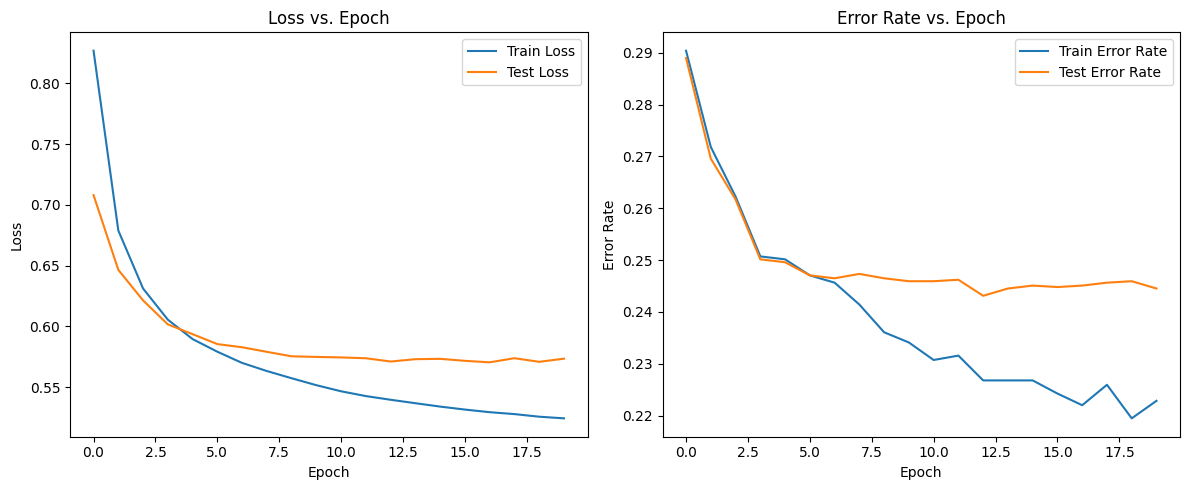

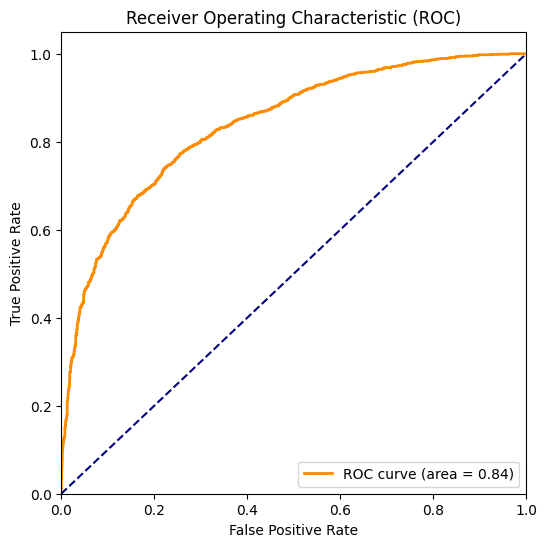

In [2]:
if __name__ == '__main__':
    GLOVE_FILE = 'D:\桌面\glove.6B\glove.6B.300d.txt'  # 根据所用的GloVe文件调整路径
    embedding_dim = 300  # 根据GloVe文件的维度设置

    glove_model = load_glove_model(GLOVE_FILE)
    trainExamples = readExamples("D:\桌面\情感分析案例(1)\情感分析案例\data\data_rt.train")  # 调整文件路径
    testExamples = readExamples("D:\桌面\情感分析案例(1)\情感分析案例\data\data_rt.test")  # 调整文件路径

    numIters = 20
    eta = 0.01

    weights = learnPredictor(trainExamples, testExamples, extractFeatures, glove_model, embedding_dim, numIters, eta)

    # 可以在训练结束后保存或进一步使用得到的weights

Loading GloVe model...
Loaded 400000 words from GloVe model.
Read 3554 examples from D:\桌面\情感分析案例(1)\情感分析案例\data\data_rt.train
Read 3554 examples from D:\桌面\情感分析案例(1)\情感分析案例\data\data_rt.test
At iteration 0, loss on training set is 0.8269461041640911, loss on test set is 0.708095783252236, error rate on training set is 0.2903770399549803, error rate on test set is 0.28897017445132245
At iteration 1, loss on training set is 0.6790041952017198, loss on test set is 0.6466169270689935, error rate on training set is 0.2718064153066967, error rate on test set is 0.26955543050084413
At iteration 2, loss on training set is 0.6312285379782764, loss on test set is 0.6214298327252253, error rate on training set is 0.2622397298818233, error rate on test set is 0.26167698368036013
At iteration 3, loss on training set is 0.6055947897248508, loss on test set is 0.6017282362658976, error rate on training set is 0.25070343275182894, error rate on test set is 0.2501406865503658
At iteration 4, loss on t

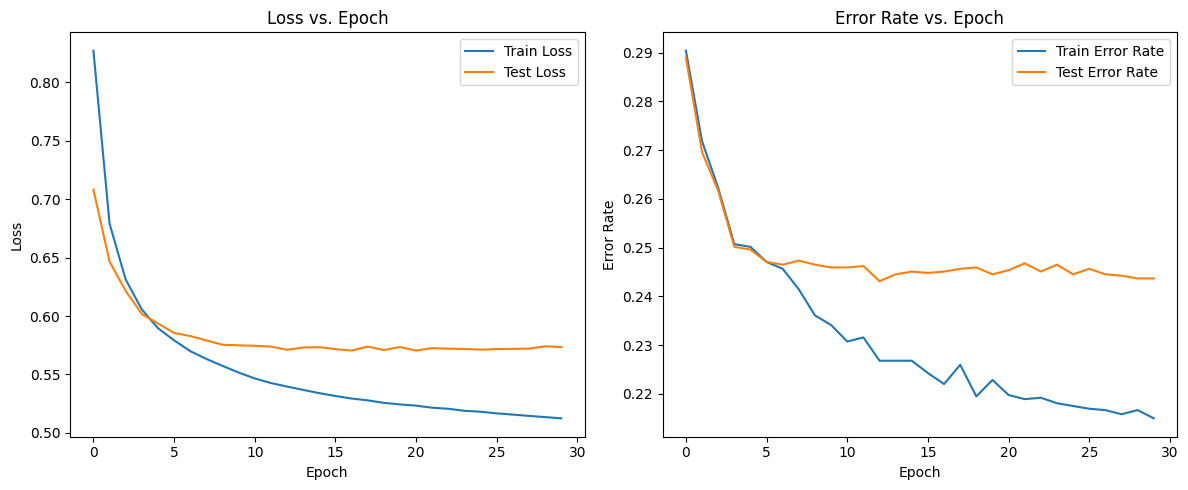

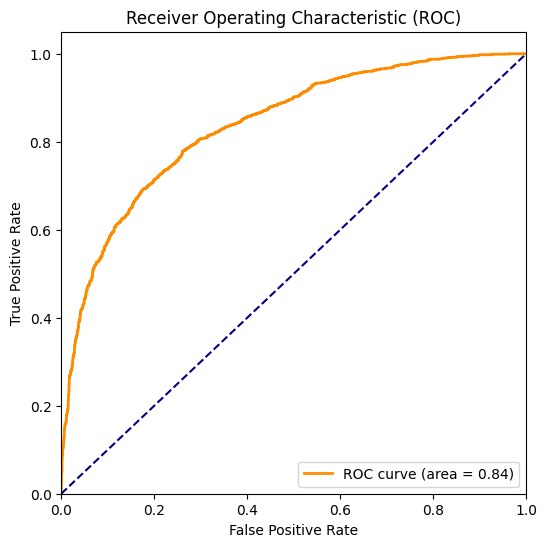

In [3]:
if __name__ == '__main__':
    GLOVE_FILE = 'D:\桌面\glove.6B\glove.6B.300d.txt'  # 根据所用的GloVe文件调整路径
    embedding_dim = 300  # 根据GloVe文件的维度设置

    glove_model = load_glove_model(GLOVE_FILE)
    trainExamples = readExamples("D:\桌面\情感分析案例(1)\情感分析案例\data\data_rt.train")  # 调整文件路径
    testExamples = readExamples("D:\桌面\情感分析案例(1)\情感分析案例\data\data_rt.test")  # 调整文件路径

    numIters = 30
    eta = 0.01

    weights = learnPredictor(trainExamples, testExamples, extractFeatures, glove_model, embedding_dim, numIters, eta)

Loading GloVe model...
Loaded 400000 words from GloVe model.
Read 3554 examples from D:\桌面\情感分析案例(1)\情感分析案例\data\data_rt.train
Read 3554 examples from D:\桌面\情感分析案例(1)\情感分析案例\data\data_rt.test
At iteration 0, loss on training set is 0.8269461041640911, loss on test set is 0.708095783252236, error rate on training set is 0.2903770399549803, error rate on test set is 0.28897017445132245
At iteration 1, loss on training set is 0.6790041952017198, loss on test set is 0.6466169270689935, error rate on training set is 0.2718064153066967, error rate on test set is 0.26955543050084413
At iteration 2, loss on training set is 0.6312285379782764, loss on test set is 0.6214298327252253, error rate on training set is 0.2622397298818233, error rate on test set is 0.26167698368036013
At iteration 3, loss on training set is 0.6055947897248508, loss on test set is 0.6017282362658976, error rate on training set is 0.25070343275182894, error rate on test set is 0.2501406865503658
At iteration 4, loss on t

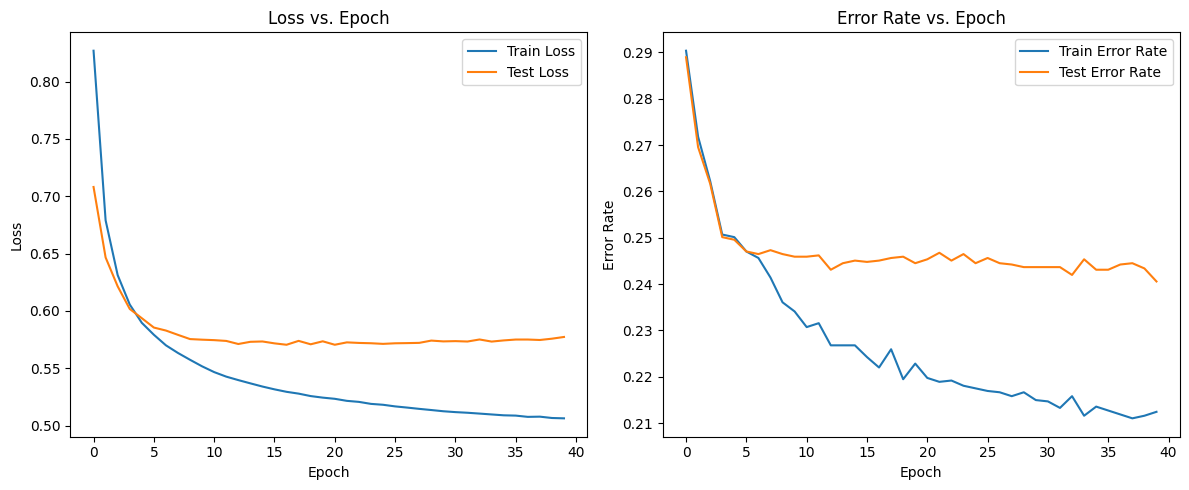

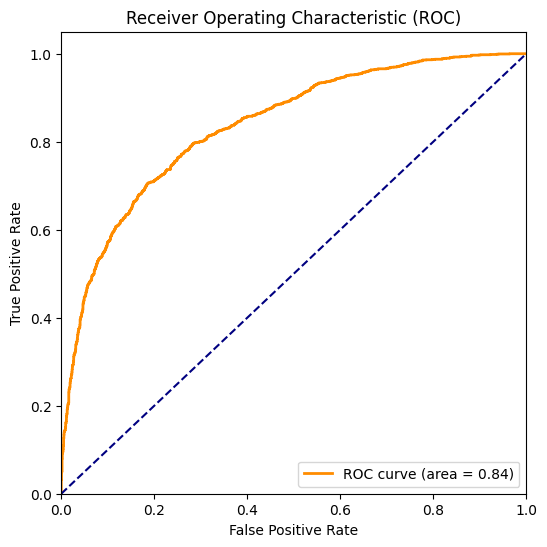

In [4]:
if __name__ == '__main__':
    GLOVE_FILE = 'D:\桌面\glove.6B\glove.6B.300d.txt'  # 根据所用的GloVe文件调整路径
    embedding_dim = 300  # 根据GloVe文件的维度设置

    glove_model = load_glove_model(GLOVE_FILE)
    trainExamples = readExamples("D:\桌面\情感分析案例(1)\情感分析案例\data\data_rt.train")  # 调整文件路径
    testExamples = readExamples("D:\桌面\情感分析案例(1)\情感分析案例\data\data_rt.test")  # 调整文件路径

    numIters = 40
    eta = 0.01

    weights = learnPredictor(trainExamples, testExamples, extractFeatures, glove_model, embedding_dim, numIters, eta)

### 模型分析

#### 1. Bag-of-Words (BoW) 模型
BoW 模型基于词袋模型，将文本表示为一个词频向量。

- **学习率 0.01**：
  - Epoch 20: 训练误差 0.027，测试误差 0.275，ROC 0.8
  - Epoch 30: 训练误差 0.014，测试误差 0.271，ROC 0.8
  - Epoch 40: 训练误差 0.007，测试误差 0.27，ROC 0.8

  从以上结果可以看出，随着 Epoch 增加，训练误差持续降低，但测试误差变化不大，表示模型在训练集上过拟合，并且ROC保持不变，未能进一步提高模型的区分能力。

- **学习率 0.001**：
  - Epoch 20: 训练误差 0.194，测试误差 0.297，ROC 0.76
  - Epoch 30: 训练误差 0.158，测试误差 0.293，ROC 0.78
  - Epoch 40: 训练误差 0.129，测试误差 0.288，ROC 0.79

  学习率较低导致训练速度变慢，但仍存在同样的问题，即训练误差不断下降，但测试集误差并未显著改善，ROC有所提高，但整体仍处于相对较低的水平。

#### 2. N-gram 模型
N-gram 模型考虑词序信息，通过提取n-gram作为特征进行文本表示。

- **学习率 0.01**：
  - Epoch 20: 训练误差 0.001，测试误差 0.326，ROC 0.74
  - Epoch 30: 训练误差 0.001，测试误差 0.331，ROC 0.74
  - Epoch 40: 训练误差 0.001，测试误差 0.328，ROC 0.74

  高学习率下，模型在训练集上表现非常好（几乎零误差），但测试误差较高，显示严重的过拟合问题。ROC维持在0.74，没有随着训练的增加而改善。

- **学习率 0.001**：
  - Epoch 20: 训练误差 0.074，测试误差 0.36，ROC 0.68
  - Epoch 30: 训练误差 0.034，测试误差 0.344，ROC 0.71
  - Epoch 40: 训练误差 0.015，测试误差 0.332，ROC 0.72

  学习率降低后，训练误差在逐步减少的同时，测试误差依旧高于训练误差，但较高学习率有所改善。此情况下，ROC 分数有所提高，但仍然较低。

#### 3. GloVe 模型
GloVe 模型通过预训练词向量对文本进行特征提取。

- **学习率 0.01**：
  - Epoch 20: 训练误差 0.22，测试误差 0.24，ROC 0.84
  - Epoch 30: 训练误差 0.21，测试误差 0.24，ROC 0.84
  - Epoch 40: 训练误差 0.21，测试误差 0.24，ROC 0.84

  GloVe 模型在训练误差和测试误差上都表现出了稳定性，且测试误差远低于BoW和N-gram模型，表示更好的泛化能力。同时 ROC分数达到0.84，表明更强的分类性能。

### 汇总分析

结合上述分析，可以得出以下结论：

1. **BoW 模型**：
   - 高学习率下容易过拟合，随着训练时间增加，训练误差显著下降，但测试误差改善有限。
   - 低学习率改善了过拟合问题，但学习较慢，ROC分数有所提高，但仍不高。

2. **N-gram 模型**：
   - 高学习率下过拟合现象严重，训练误差几乎为零，但测试误差高。
   - 低学习率略微改善了过拟合，但测试误差仍相对较高，且ROC分数不理想。

3. **GloVe 模型**：
   - 较其他两种模型表现更加稳定，即使在高学习率下，也能保持较好的训练和测试性能。
   - 其测试误差明显低于其他模型，且ROC分数最高，表明其能捕捉到更有效的特征进行分类。

### 改进方向

1. **BoW 和 N-gram 模型**：
   - **正则化**：通过L2正则化等办法防止过拟合。
   - **调参**：进一步调整学习率和Epoch数，以找到更合适的组合。
   - **使用高级特征**：考虑引入TF-IDF特征，增强特征表征能力。

2. **GloVe 模型**：
   - **增强GloVe表示**：采用更大的预训练词向量或者使用更复杂的词向量模型（如FastText、Word2Vec）。
   - **混合模型**：结合BoW或N-gram特征，构建混合模型以捕捉更多细节信息。
   - **深度网络**：引入简单的深度神经网络（如RNN或CNN），充分利用GloVe词向量的特性，进一步提升性能。


